<a href="https://colab.research.google.com/github/hsudhakaran/test_jax/blob/main/sig_img_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
# from tensorflow.keras.datasets import mnist
from flax import linen as nn
import flax.training.checkpoints
import matplotlib.pyplot as plt
%matplotlib inline
import pdb
import optax
import copy
import torch
import pdb
import math
from torch.nn import functional as F
import copy
from PIL import Image
import requests
from typing import Optional, Sequence, Union

In [2]:
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig, SiglipModel

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
# vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))
vision_model = SiglipModel.from_pretrained("google/siglip-base-patch16-224")

vision_model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

SiglipModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(32000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768

In [30]:
!curl -L 'https://www.ncaa.org/images/2021/7/22/MBA_Ball.JPG?width=1884&quality=80&format=jpg' --output image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   280  100   280    0     0    212      0  0:00:01  0:00:01 --:--:--   212
100  222k  100  222k    0     0  63455      0  0:00:03  0:00:03 --:--:--  117k


(2, 64)
{'input_ids': array([[ 291,  269,  262,  266, 1304,  267,  262,  266, 6722,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1],
       [ 291,  269,  262,  266, 1304,  267,  454, 3014,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1]]), 'pixel_values': array([[[[ 0.6862745 ,  0.6627451 ,  0.6784314 , ...,  0.6784314 ,
           0.6784314 ,  0.6

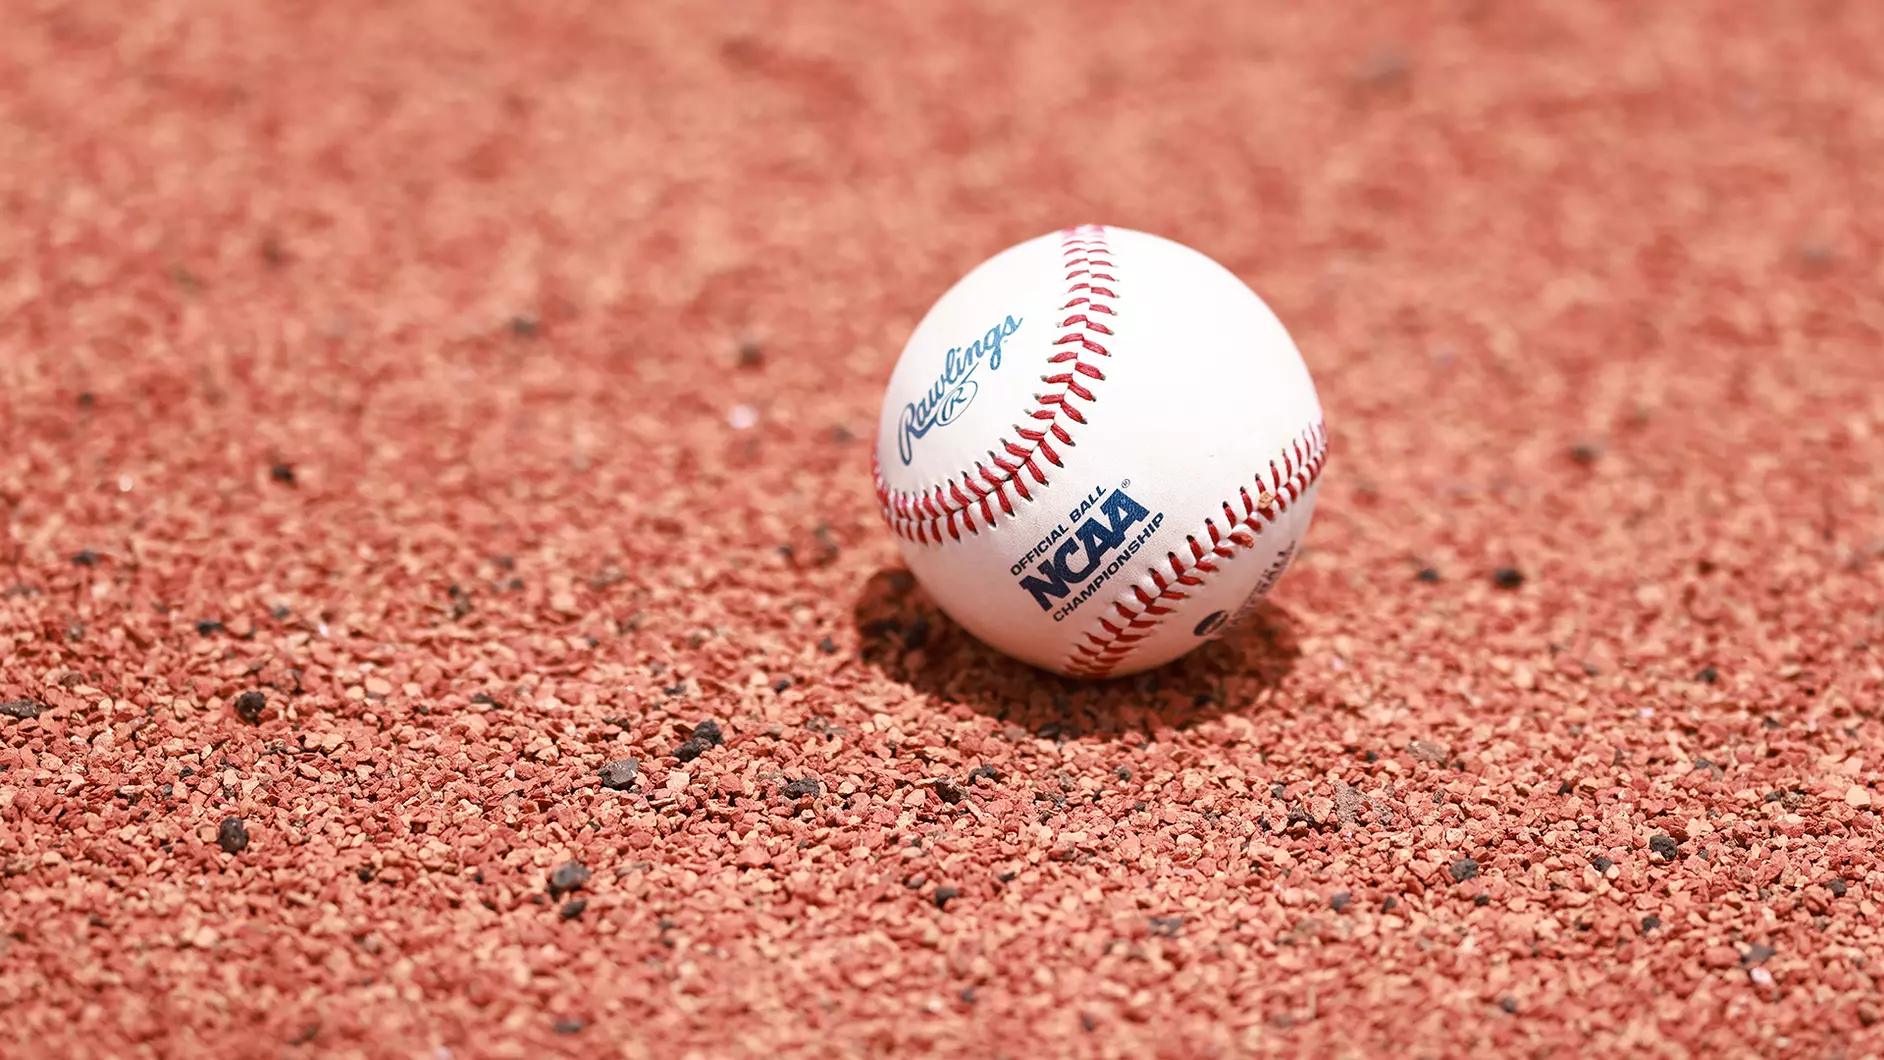

In [34]:
# url = "http://i.imgur.com/8o9DXSj.jpeg"
image = Image.open("image.jpg")

candidate_labels = ["a baseball", "2 dogs"]
# follows the pipeline prompt template to get same results
texts = [f'This is a photo of {label}.' for label in candidate_labels]
# important: we pass `padding=max_length` since the model was trained with this
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="np")
print(inputs['input_ids'].shape)
print(inputs)
image

# Vision Model

In [3]:
key = jax.random.PRNGKey(42)
xtr = jax.random.normal(key, (1,224,224, 3))

In [4]:
class SiglipVisionEmbeddingsFlax(nn.Module):
    """Siglip Vision Embeddings Network"""

    num_channels: int = 3
    embed_dim: int = 768
    image_size: int = 224
    patch_size: int = 16

    @nn.compact
    def __call__(self, inputs):

        patch_embeds = nn.Conv(
          features=self.embed_dim,
          kernel_size=(self.patch_size, self.patch_size),
          strides=(self.patch_size, self.patch_size),
          padding="VALID",
          name="patch_embedding"
        )(inputs)
        num_patches = (self.image_size // self.patch_size) ** 2
        num_positions = num_patches
        position_ids = jnp.arange(num_positions)[None, :]
        embeddings = patch_embeds.reshape(patch_embeds.shape[0], num_patches, self.embed_dim)  # (B, num_patches, embed_dim)
        pos_embeds = nn.Embed(num_embeddings=num_positions,
                              features=self.embed_dim,
                              name="position_embedding")(position_ids)
        embeddings = embeddings + pos_embeds
        return embeddings

In [12]:
class SiglipAttentionFlax(nn.Module):
    embed_dim: int = 768
    num_heads: int = 12
    dropout: float = 0.0

    @nn.compact
    def __call__(self, x, deterministic=True):

        y = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            kernel_init=nn.initializers.xavier_uniform(),
            deterministic=deterministic,
            dtype="float32",
        )(x, x)


        return y

In [23]:
class SiglipMLPFLax(nn.Module):
    hidden_size: int = 768  # Example default value
    intermediate_size: int = 3072

    @nn.compact
    def __call__(self, hidden_states):
        # Apply first linear layer
        hidden_states = nn.Dense(features=self.intermediate_size, name='fc1')(hidden_states)

        # Apply GELU activation (Flax uses jax.nn.gelu)
        hidden_states = nn.gelu(hidden_states, approximate=True)

        # Apply second linear layer
        hidden_states = nn.Dense(features=self.hidden_size, name='fc2')(hidden_states)

        return hidden_states

In [19]:
class SiglipEncoderLayerFlax(nn.Module):
    embed_dim: int = 768
    layer_norm_eps: float = 1e-6

    @nn.compact
    def __call__(self, hidden_states):
        residual = hidden_states
        hidden_states = nn.LayerNorm(epsilon=self.layer_norm_eps, name='layer_norm1')(hidden_states)
        hidden_states = SiglipAttentionFlax()(hidden_states)
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = nn.LayerNorm(epsilon=self.layer_norm_eps, name='layer_norm2')(hidden_states)
        hidden_states = SiglipMLPFLax()(hidden_states)
        hidden_states = residual + hidden_states
        return hidden_states

In [20]:
class SiglipEncoderFlax(nn.Module):
    num_hidden_layers: int = 12 # number of hidden layers in the encoder as in the paper

    @nn.compact
    def __call__(self, hidden_states):
        # Apply each layer sequentially
        for lyr in range(self.num_hidden_layers):
            hidden_states = SiglipEncoderLayerFlax(name=f"layers_{lyr}")(hidden_states)
        return hidden_states

In [21]:
class SiglipVisionTransformer(nn.Module):
    layer_norm_eps: float = 1e-6

    @nn.compact
    def __call__(self, pixel_values):
        hidden_states = SiglipVisionEmbeddingsFlax()(pixel_values)
        last_hidden_state = SiglipEncoderFlax()(hidden_states)
        last_hidden_state = nn.LayerNorm(epsilon=self.layer_norm_eps)(last_hidden_state)
        return last_hidden_state

In [24]:
flaxSigVisModel = SiglipVisionTransformer()
flaxSigVisModel_params = flaxSigVisModel.init(jax.random.PRNGKey(4322), xtr)
flaxSigVisModel_params['params'].keys()

dict_keys(['SiglipVisionEmbeddingsFlax_0', 'SiglipEncoderFlax_0', 'LayerNorm_0'])

In [25]:
n_params = sum(p.size for p in jax.tree_util.tree_leaves(flaxSigVisModel_params))

print(f"Total number of parameters in Flax Model: {n_params:_}")

Total number of parameters in Flax Model: 85_797_120


In [27]:
class MAPHead(nn.Module):
  """Multihead Attention Pooling."""
  num_heads: int = 12

  @nn.compact
  def __call__(self, x):
    # TODO
    n, l, d = x.shape  # pylint: disable=unused-variable
    probe = self.param("probe", nn.initializers.xavier_uniform(),
                       (1, 1, d), x.dtype)
    probe = jnp.tile(probe, [n, 1, 1])

    x = nn.MultiHeadDotProductAttention(
        num_heads=self.num_heads,
        kernel_init=nn.initializers.xavier_uniform())(probe, x)

    # TODO: dropout on head?
    y = nn.LayerNorm()(x)
    x = x + SiglipMLPFLax()(y)
    return x[:, 0]

In [28]:
class SiglipVisionModel(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = SiglipVisionTransformer()(x)
        x = MAPHead()(x)

        return x

In [29]:
flaxSigVisModel = SiglipVisionModel()
flaxSigVisModel_params = flaxSigVisModel.init(jax.random.PRNGKey(4322), xtr)
print(flaxSigVisModel_params['params'].keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(flaxSigVisModel_params))

print(f"Total number of parameters in Flax Model: {n_params:_}")

dict_keys(['SiglipVisionTransformer_0', 'MAPHead_0'])
Total number of parameters in Flax Model: 92_884_224


# Text Model

In [40]:
class SiglipTextEmbeddingsFlax(nn.Module):
    """Siglip Text Embeddings Network"""

    vocab_size: int = 32000
    block_size: int = 64
    embed_size: int = 768


    @nn.compact
    def __call__(self, x, training: bool):
        embeddings = nn.Embed(self.vocab_size, self.embed_size, name='token_embedding')(x) + nn.Embed(self.block_size, self.embed_size, name='position_embedding')(jnp.arange(self.block_size))
        return embeddings

In [41]:
sigTextEmbModel = SiglipTextEmbeddingsFlax()
sigTextEmbModel_params = sigTextEmbModel.init(jax.random.PRNGKey(4322), inputs['input_ids'], True)
sigTextEmbModel_params['params'].keys()

dict_keys(['token_embedding', 'position_embedding'])

(64, 768)